In [1]:
# Copied from https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions
# Modified the code to make it more generic 
# Included "hard coded data" for Turkey and Republic of Ireland (ROI)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Curve Fitting

## 1 - Logistic regression

In [3]:
# The logistic model describes ain infection growth that is going to stop in the future, 

In [4]:
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



## 2 - Exponential growth

In [5]:
# The exponential model describes an unstoppable infection

In [6]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

## 3 - Generic code for curve fitting

In [7]:
def fit_curve(model_function, x, y, p0):
    fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000)
    # print("fit_result: {}".format(fit))
    a , b, c = fit[0]
    # standard error 
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    return a , b, c, errors

##  4 - Plot & evaluate

In [8]:
# TODO convert func, abc_tuple into struct and pass array of that struct
def plot_curves(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    
    def calculate_sol(x, logistic_model_func, a_lr, b_lr, c_lr):
        # The expected infection end can be calculated as that particular day at which the cumulative 
        # infected people count is equal to the c parameter rounded to the nearest integer.
        sol = int(fsolve(lambda x : logistic_model_func(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
        return sol

    sol = calculate_sol(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    plt.plot(x+pred_x, 
             [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
             label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, 
             [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x+pred_x], 
             label="Exponential model" )
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,abc_tuple_lr[2]*1.1))
    plt.show()

In [9]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
def calculate_mse(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    y_pred_logistic = [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x]
    y_pred_exp =  [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x]
    mse_lr = mean_squared_error(y,y_pred_logistic)
    mse_exp = mean_squared_error(y,y_pred_exp)
    return mse_lr, mse_exp

# Execute logistic regression & exponential growth

## 1 - Data on Italy

### 1.1 - Load data

In [10]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [11]:
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


In [12]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

In [13]:
df.head()

,data,totale_casi
0,54,229
1,55,322
2,56,400
3,57,650
4,58,888


In [14]:
# Data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [15]:
# p0: Initial guess for the parameters (length N)
population = 60.48 * 1e6# 60.48 million
start_date = 54 # 54th day of the year

p0_b = 45 + start_date # # i.e. peak after 45 days
p0_c = 0.03 * population # %3 of the population (60.48 million)
p0_lr = [2, p0_b, p0_c ] 
p0_exp = [1,1,1]

### 1.2 - Execute Logistic Regression

In [16]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:4.881537919511968 , b_lr:79.20266285421107, c_lr:94246.05084129177 
errors_lr: [0.12568430307096876, 0.5997888052199305, 6330.6595054720365]


In [17]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

149


In [18]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
# sol = 149 --> May 28

### 1.3 - Execute Exponential Growth

In [19]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:2.578149306985978 , b_exp:0.1524250351776442, c_exp:14.40640481640886 
errors_exp: [2041473.718918872, 0.0037864844566922844, 5191620.102892771]


### 1.4 - Plot

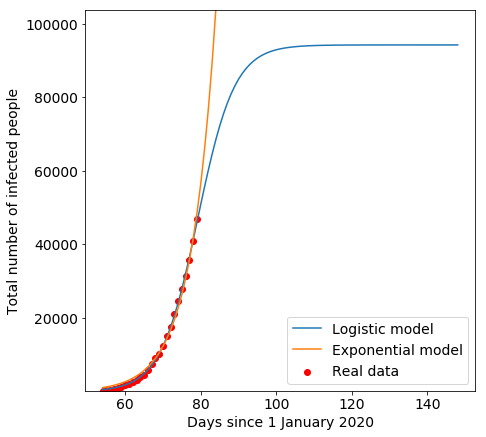

In [20]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 1.5 - Evaluate

In [21]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [22]:
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 165089.10186567897
Exponential model MSE: 1122753.6542659076


## 2 - Data on Republic of Ireland

### 2.1 - Load data

In [23]:
# TODO Get data automatically from some source
# Starts at Feb 29
# Analysis ends at March 20
total_cases = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557, 683]
dates = list(range(60, 81))

In [24]:
# Data
x = dates
y = total_cases

In [25]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
population = 4.83 * 1e6 # 4.83 million
start_date = 60 # start_date-th day of the year

p0_b = 45 + start_date # # i.e. peak after 45 days
p0_c = 0.03 * population # %3 of the population 
p0_lr = [2, p0_b, p0_c ] 
p0_exp = [1,1,1]

### 2.2 - Execute Logistic Regression

In [26]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:3.2998470081972027 , b_lr:87.41080525605268, c_lr:7233.0671566851925 
errors_lr: [0.21560752505495398, 4.842688112197328, 8742.487231322697]


In [27]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

125


In [28]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
# sol = 125 --> May 4, 2020 

### 2.3 - Execute Exponential Growth

In [29]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:2.4090637875263564e-06 , b_exp:0.28831741880197037, c_exp:12.42829110077876 
errors_exp: [1.3201341495064527, 0.008659849799532824, 1900634.5541933365]


### 2.4 - Plot

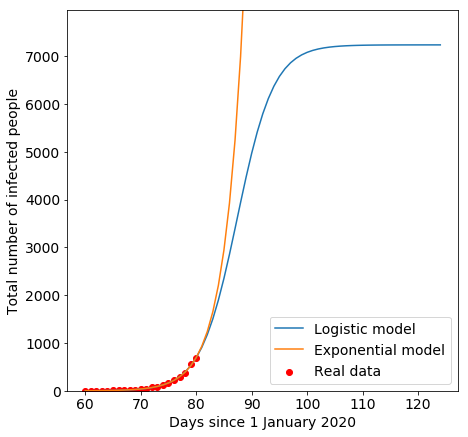

In [30]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 2.5 - Evaluate

In [31]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 106.69309307366673
Exponential model MSE: 110.56735372612263


## 3 - Data on Turkey

### 3.1 - Load data

In [32]:
# TODO Get data automatically from some source
# Starts at March 11
# Analysis ends at March 20
total_cases = [1, 2, 5, 6, 18, 47, 98, 191, 358, 670]
dates = list(range(71, 81))

In [33]:
# Data
x = dates
y = total_cases

In [34]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
population = 80.81 * 1e6 # 80.81 million
start_date = 71 # start_date-th day of the year

p0_b = 45 + start_date  # i.e. peak after 45 days
p0_c = 0.03 * population # %3 of the population 
p0_lr = [2, p0_b, p0_c] 
p0_exp = [1,1,1]

### 3.2 - Execute Logistic Regression

In [35]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:1.4170777128874685 , b_lr:82.25433535917306, c_lr:3954.3712367096514 
errors_lr: [0.048266657166596956, 0.6104223117851448, 1250.5867313769122]


In [36]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
sol = int(fsolve(lambda x : logistic_model(x,a_lr,b_lr,c_lr) - int(c_lr),b_lr))
print(sol) 

95


In [37]:
# checked from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
# sol = 95 --> April 4, 2020 

### 3.3 - Execute Exponential Growth

In [38]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model,x,y,p0=p0_exp)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:3.2535728649254093e-16 , b_exp:0.6416832852997824, c_exp:14.278275387567536 
errors_exp: [7.886527159326957e-10, 0.027425435443799488, 3777503.361524101]


### 3.4 - Plot

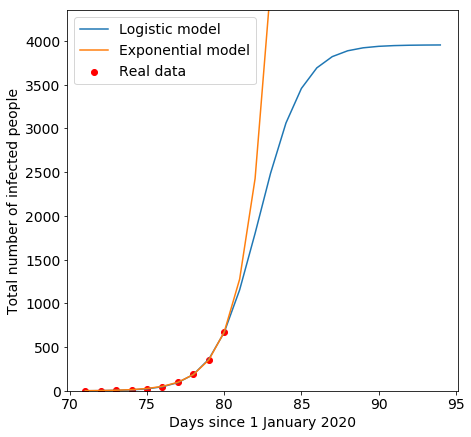

In [39]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 3.5 - Evaluate

In [40]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 10.215437577472997
Exponential model MSE: 23.01412793997658
